##  DonorsChoose- Part 2. Exploratory Analysis

**<a href='#1'>1. Introduction</a><br>**
**<a href='#2'>2. Get Data</a><br>**
**<a href='#3'>3. Understanding Donations </a><br>**
<a href='#3.1'>3.1 What is the percentage of repeated donors?</a><br>
<a href='#3.2'>3.2 Does the 80-20 rule apply to donations? </a><br>
<a href='#3.3'>3.3 What are the popular project categories? </a><br>
**<a href='#4'>4. Understanding Individual Donors </a><br>**
<a href='#4.1'>4.1. Bubble Map of donations </a><br>
<a href='#4.2'>4.2. Breakdown of donations by a variety of methods </a><br>
<a href='#4.3'>4.3  How is donation distributed amongst the top 10 school that a donor donates to?</a><br> 
<a href='#4.4'>4.4  How is donation distributed across different percentages of free lunch received by schools?</a><br> 
<a href='#4.5'>4.5  How is project resources distributed across different subject categories?</a><br> 
<a href='#4.6'>4.6  What is the donor's donation pattern through time?</a><br> 
**<a href='#5'>5. K-Means clustering of donors  </a><br>**


 ### <a id='1'>1. Introduction</a>

DonorsChoose.org is an organization that helps teachers fundraise for American classrooms. The organization has funded over 1.1 million classroom requests through the support of 3 million donors, the majority of whom were making their first-ever donation to a public school. If DonorsChoose.org can motivate even a fraction of those donors to make another donation, that could have a huge impact on the number of classroom requests fulfilled. The goal of the project is to enable DonorsChoose.org to build targeted email campaigns, recommending specific classroom requests to prior donors. 

This notebook is Part 2 of 3 notebooks.  Part 1 focuses on Feature Engineering, Part 2 focuse on Data Exploration, and Part 3 will focus on building the recommender system and evaluating the model.  

This notebook will focus on exploring the dataset to understand the behavior of the donors, where the donations are coming from, and finally, to gain insights into building an effective recommender system,  <br>

This notebook depends on dataframes generated from "DonorsChoose- Part 1. Preprocessing & Feature Engineering".

[Link to competition description:](https://www.kaggle.com/donorschoose/io)

 ### <a id='2'>2. Get Data</a>

In [1]:
import numpy as np
import pandas as pd 
import os
import requests
import datetime as dt
import pickle
import gc
from math import sin, cos, sqrt, atan2, radians
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.offline.init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
schools= pd.read_pickle('schools.pkl')
donors= pd.read_pickle('donors.pkl')
projects= pd.read_pickle('projects.pkl')
donations= pd.read_pickle('donations.pkl')
resources= pd.read_pickle('resources.pkl')
teachers= pd.read_pickle('teachers.pkl')

donorFeatureMatrixNoAdj = pd.read_pickle('donorFeatureMatrixNoAdj.pkl') #prior to 2018
donorFeatureMatrix = pd.read_pickle('donorFeatureMatrix.pkl') # prior to 2018'schools', 'teachers']

### <a id='3'>3. Understanding Donations</a>

The analysis will focus on what prompts the donors to make multiple contributions. The hope is that if we can understand why a donor chooses to donate again, we can hopefully apply what we learned to the donors that have only contributed once so far.

### <a id='3.1'>3.1 What is the percentage of repeated donors?</a>

In the donations dataset, the time frame is between 10/2012 and 5/2018.  There are about 2 million unqiue donors.  There are donors that have donated more than once in the past, with cart number > 1, but will only have one donation in this dataset due to prior years are not captured.  There are also donors who only had one cart, but in the cart, donated to multiple projects.  There are also people who have multiple cart, but always donated to the same project.

31% of donors in the dataset have donated more than once <br>
24% of donors in the dataset donated to multiple projects <br>
69% donated only once so far, in another words, have only 1 cart <br> 
0.74% of donors donated only once so far, but have donated to multiple projects in their cart <br>


In [3]:
allDonors = set(donations['Donor ID'])
totalDonors = len(allDonors)
print("There are " + "{:,}".format(totalDonors) + " unique donors in the donations dataset")

multipleCartDonors = set(donations[donations['Donor Cart Sequence'] > 1]['Donor ID'])
print("% of donors donated multiple times (multiple carts): ", "{0:.2f}".format(len(multipleCartDonors)/totalDonors*100))

singleCartDonors = allDonors.difference(multipleCartDonors) # new set with elements in s but not in t
print("% of donors donated once: ", "{0:.2f}".format(len(singleCartDonors)/totalDonors*100))

# Since a donor can donate to multiple projects in a single Cart, 
#let us find the donors that only donated once so far, but in that cart, donated to multiple projects.
temp = donations.groupby(['Donor ID']).agg({'Project ID': 'nunique'})
multipleProject = temp[temp['Project ID'] > 1]
multipleProjectDonors = set(multipleProject.index)
print("% of donors donated to multiple projects: ", "{0:.2f}".format(len(multipleProjectDonors)/totalDonors*100))

singleCartmultipleProjectDonors = singleCartDonors.intersection(multipleProjectDonors)
print("% of donors donated to multiple projects but only donated once: ", "{0:.2f}".format(len(singleCartmultipleProjectDonors)/totalDonors*100))


There are 2,003,194 unique donors in the donations dataset
% of donors donated multiple times (multiple carts):  31.18
% of donors donated once:  68.82
% of donors donated to multiple projects:  23.60
% of donors donated to multiple projects but only donated once:  0.73


### <a id='3.2'>3.2 Does the 80-20 rule apply to donations?</a>

The Pareto principle, also known as the 80/20 rule,  states that, for many events, roughly 80% of the effects come from 20% of the cause.  <br>
In the donations dataset: <br>
top 1% donors provided 36% of the fundings <br>
top 5% donors provided 56% of the fundings <br>
top 10% donors provided 66% of the fundings <br>
top 25% of donors provided 80% of the fundings <br>

Text(0.5,1,'Top 25% of donors provided 80% of the fundings ')

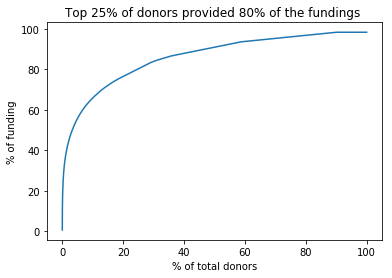

In [4]:
donorTotal = donations.groupby(['Donor ID']).agg({'Donation Amount': 'sum',  'Donor ID': 'count', 'Project ID':'nunique'}).sort_values(by = ['Donation Amount'], ascending=False)
donorTotal = donorTotal.rename(columns={'Donation Amount':'Total Donation Amount', 'Donor ID':'Total Donation Occurances', 'Project ID':'Total Projects'}).reset_index()
donorTotal['% Total Donation'] = donorTotal['Total Donation Amount']/sum(donorTotal['Total Donation Amount'])*100
donorTotal['cumulative % of total donations'] = donorTotal['% Total Donation'].cumsum()
donorTotal = donorTotal.reset_index()
donorTotal['cumulative % of total donors'] =  donorTotal['index']/totalDonors*100
donorTotal.loc[donorTotal['cumulative % of total donors'] > 10].head(1)

plt.plot(donorTotal['cumulative % of total donors'], donorTotal['cumulative % of total donations'])
plt.xlabel('% of total donors')
plt.ylabel('% of funding')
plt.title('Top 25% of donors provided 80% of the fundings ')

### <a id='4'>4. Create dashboard to analyze an individual donor</a>

In this section, tools are created to understand one individual donor, hopefully will shed insights on different donor behaviors.  

### <a id='4.1'>4.1 Bubble map of donations</a>

The bubble map will map the donation amount in each cities.  The chart is colored into groups, according to the percentile of the donation amount in the city relative to the total amount donated by the donor.  

In [7]:
def merge_data(idList):
    ''' 
    Filter data based on a list of Donor ID.  Merge all data together into one dataframe.  
    Arguments: list of 'Donor ID'
    Returns: dataframe 
    '''
    temp = donations[donations['Donor ID'].isin(idList)].reset_index(drop = True)
    temp = temp.merge(donors, on = 'Donor ID', how='left')
    temp = temp.merge(projects, on = 'Project ID', how = 'left')
    temp = temp.merge(resources, on = 'Project ID', how = 'left')
    temp = temp.merge(schools, on = 'School ID', how = 'left')
    temp = temp.merge(teachers, on = 'Teacher ID', how = 'left')
    
    return temp


def summarize_by_city(df):
    ''' 
    Calculate donation amount in each city and scale to be used in the plot.
    '''
    df['cityTotal'] = df['Donation Amount'].groupby(df['School City']).transform('sum')
    chartData = df.groupby('School City').first().sort_values(by = 'cityTotal', ascending=False).reset_index()
    chartData = chartData[['School City','cityTotal', 'School_Lon', 'School_Lat', 'Donor City', 'Donor_Lat', 'Donor_Lon']].copy(deep = True)
    chartData['text'] = chartData['School City'] + ': $' + chartData['cityTotal'].apply('{0:,.0f}'.format).astype(str)

    # define cuts for plot
    top01 = chartData['cityTotal'].quantile(0.999)
    top1 = chartData['cityTotal'].quantile(0.99)
    top10 = chartData['cityTotal'].quantile(0.9)
    top50 = chartData['cityTotal'].quantile(0.5)
    topMax = chartData['cityTotal'].max()+1
    
    # bin donation
    chartData['group'] = pd.cut(chartData['cityTotal'],np.array([-0.1, top50, top10, top1, top01, topMax]), 3,
                           labels = ['Bottom 50%','11-50%', 'Top 2-10%', 'Top 1%', 'Top 0.01%'])
    
    # calculate scale
    scale = chartData['cityTotal'].median()
    return chartData, scale

def get_chart_index(chartData):
    ''' 
    Since the bubble map has various groupings according to the percentile of the donation, this function
    identifies the row numbers of the data to plot in each grouping as well as the colors for each group.
    '''
    x = chartData['group'].value_counts()
    x = x.reindex(index = ['Top 0.01%', 'Top 1%', 'Top 2-10%', '11-50%', 'Bottom 50%'])
    x = x.loc[x>0]
    numX = len(x.loc[x>0])
    limx = 0
    limits = []
    colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)", "rgb(232,255,184)"]
    
    # get colors:
    colors = colors[0:numX]
    colors.append('lightgrey')
    
    # get limits 
    # Not all datasets have value in every group, so we loop through the available values only
    for i in range(numX):
        limy = limx+x[i]
        limitEntry = (limx, limy)
        limx = limy
        limits.append(limitEntry)

    return limits, colors

def prepare_cities_donation(chartData, scale, limits, colors):
    ''' 
    prepare data into the format that plotly used for bubble map
    this applies to cities that the donor donated to
    '''
    cities = []
    for i in range(len(limits)):
        lim = limits[i]
        df_sub = chartData[lim[0]:lim[1]]
        city = dict(
            type = 'scattergeo',
            locationmode = 'USA-states',
            lon = df_sub['School_Lon'],
            lat = df_sub['School_Lat'],
            text = df_sub['text'],
            marker = dict(
                size = df_sub['cityTotal']/scale,
                color = colors[i],
                line = dict(width=0.5, color='rgb(40,40,40)'),
                sizemode = 'area'),
            name = df_sub.iloc[0]['group'])
            #name = '{0} - {1}'.format(lim[0],lim[1]) )
        cities.append(city)
    return cities

def donor_city_total(chartData):
    '''
    Calculate the amount that the donor donates to his/her home city
    '''
    donorHome = chartData['Donor City'][0]
    if (chartData['School City'] == donorHome).sum()>0:
        donorCityTotal = chartData[chartData['School City'] == donorHome]['cityTotal'].apply('{0:,.0f}'.format).astype(str)
        donorTotal = chartData[chartData['School City'] == donorHome]['cityTotal']
    else:
        donorCityTotal = '0'
        donorTotal = 0
    return donorCityTotal, donorTotal, donorHome 

def prepare_donor_donation(chartData, donorTotal, donorCityTotal, scale, donorHome):
    ''' 
    prepare data into the format that plotly used for bubble map
    this applies to donation in the donor's home town
    '''
    donorCity = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = max(chartData['Donor_Lon']),
        lat = max(chartData['Donor_Lat']),
        text = "Donor's City: " + donorHome + " $" + donorCityTotal,
        marker = dict(
            size = donorTotal/scale,
            color = 'rgb(40,40,40)',
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'),
        name = "Donor's City")
    return donorCity

def plot_bubble_map(idList):
    '''
    Run list of data preparation steps in order to plot the bubble map
    '''
    df = merge_data(idList)
    chartData, scale = summarize_by_city(df)
    limits, colors = get_chart_index(chartData)
    cities = prepare_cities_donation(chartData, scale, limits, colors)
    donorCityTotal, donorTotal, donorHome  = donor_city_total(chartData)
    donorCity = prepare_donor_donation(chartData, donorTotal, donorCityTotal, scale, donorHome)

    cities.append(donorCity)

    layout = dict(
            title = 'Donation by City<br>(Click legend to toggle traces)',
            showlegend = True,
            geo = dict(
                scope='usa',
                projection=dict( type='albers usa' ),
                showland = True,
                landcolor = 'rgb(217, 217, 217)',
                subunitwidth=1,
                countrywidth=1,
                subunitcolor="rgb(255, 255, 255)",
                countrycolor="rgb(255, 255, 255)"
            ),
        )
    fig = dict( data=cities, layout=layout )
    
    return py.offline.iplot(fig, validate=False, filename='donation map' )

In [8]:
idList = ['4416745560343f14a74dedcda4ec03b0']
plot_bubble_map(idList)

### <a id='4.2'>4.2 Breakdown of donations by a variety of methods</a>

Define function to view table in Pivot Format.

In [9]:
def stacked_chart_data(dframe, index, values, columns, orderBy, xAxisOrder = None):
    chartData = pd.pivot_table(dframe,
                               index = index,
                               values = values,
                               columns = columns,
                               aggfunc=[np.sum],
                               fill_value = 0 )
    chartData.columns = chartData.columns.droplevel()
    
    # if want to re-order x-axis
    if xAxisOrder is not None:
        chartData = chartData.reindex(xAxisOrder)
        
    else: 
        # Re-order columns in the data (re-order index in chartData).  
        temp = pd.pivot_table(dframe,
                              index = index,
                              values = values,
                              aggfunc=[np.sum],
                              fill_value = 0 )
        temp.columns = temp.columns.droplevel()
        temp = temp.reindex(temp.sort_values(by = values, ascending=False).index)
        newXAxisOrder = list(temp.index)
        chartData = chartData.reindex(newXAxisOrder)


    # Re-order legends in the data. Highest in the fill should be Project Resource Category with highest donation amount.
    temp = pd.pivot_table(dframe,
                              index = orderBy,
                              values = values,
                              aggfunc=[np.sum],
                              fill_value = 0 )
    temp.columns = temp.columns.droplevel()
    temp = temp.reindex(temp.sort_values(by = values, ascending=True).index)
    newColOrder = list(temp.index)
    chartData = chartData[newColOrder]

    return chartData

Define function to plot a stacked bar chart using Plotly.

In [10]:
def stacked_bar(chartData, title):
    
    # create empty list to store data
    data = []

    # each category is a separate trace on the stacked chart
    for colName in chartData.columns:
        data.append({
            'type' : 'bar',
            'x' : chartData.index,
            'y' : chartData[colName],
            'name' : colName
        })

    # Set layout
    layout = go.Layout(
        barmode='stack', 
        title = "Total Donation by "+ title
    )

    # Plot figure
    fig = go.Figure(data=data, layout=layout)
    # py.offline.iplot(fig, filename='stacked-bar')
    
    return py.offline.iplot(fig, filename='stacked-bar')

Define function to plot stacked horizontal bar.

In [11]:
def stacked_horiz_bar(chartData, title):
    
    # reverse chartData for horizontal chart.  Highest number on top
    chartData = chartData.reindex(index=chartData.index[::-1])
    
    # create empty list to store data
    data = []

    # each category is a separate trace on the stacked chart
    for colName in chartData.columns:
        data.append({
            'type' : 'bar',
            'y' : chartData.index,
            'x' : chartData[colName],
            'name' : colName,
            'orientation' : 'h'
        })

    # Set layout
    layout = go.Layout(
        barmode='stack', 
        title = "Total Donation by "+ title,
        font= dict(size=12),
        margin=go.Margin(l=200)
    )


    # Plot figure
    fig = go.Figure(data=data, layout=layout)
    # py.offline.iplot(fig, filename='stacked-bar')
    
    return py.offline.iplot(fig, filename='stacked-bar')

In [12]:
index = 'Project Grade Level Category'
values = 'Donation Amount'
columns = 'Project Resource Category'
xAxisOrder = ['Grades PreK-2', 'Grades 3-5', 'Grades 6-8', 'Grades 9-12']

orderBy = 'Project Resource Category'

chart = stacked_chart_data(df, index, values, columns, orderBy, xAxisOrder)
stacked_bar(chart, index)

In [13]:
index = 'School Metro Type'
values = 'Donation Amount'
columns = 'Project Resource Category'
xAxisOrder = None
orderBy = 'Project Resource Category'
chart = stacked_chart_data(df, index, values, columns, orderBy, xAxisOrder)
stacked_bar(chart, index)

### <a id='4.3'>4.3 Analysis: How is donation distributed amongst the top 10 school that a donor donates to?</a>

In [14]:
index =  'School Name'
values = 'Donation Amount'
columns = 'Project Resource Category'
xAxisOrder = None
orderBy = 'Project Resource Category'

chart = stacked_chart_data(df, index, values, columns, orderBy, xAxisOrder)

chart_1 = chart[0:10].copy(deep = True)
chart_1.loc[len(chart_1)] = chart[10:].sum(axis = 0)
chart_1 = chart_1.rename(index={10: 'Others'})
stacked_horiz_bar(chart_1, 'Top 10 Schools')


### <a id='4.4'>4.4 Analysis: How is donation distributed across different percentages of free lunch received by schools?</a>

In [15]:
index = 'School Percentage Free Lunch'
values = 'Donation Amount'
columns = 'Project Resource Category'
xAxisOrder = None
orderBy = 'Project Resource Category'

chart = stacked_chart_data(df, index, values, columns, orderBy, xAxisOrder)
stacked_horiz_bar(chart, index)

### <a id='4.5'>4.5 Analysis: How is project resources distributed across different subject categories?</a>

In [16]:
index = 'Project Resource Category'
values = 'Donation Amount'
columns = 'Project Subject Subcategory Tree'
xAxisOrder = None
orderBy = 'Project Subject Subcategory Tree'

chart = stacked_chart_data(df, index, values, columns, orderBy, xAxisOrder)
stacked_bar(chart, index+' & '+columns)

In [17]:
index = 'Project Resource Category'
values = 'Donation Amount'
columns = 'Project Subject Category Tree'
xAxisOrder = None
orderBy = 'Project Subject Category Tree'

chart = stacked_chart_data(df, index, values, columns, orderBy, xAxisOrder)
stacked_bar(chart, index+' & '+columns)

### <a id='4.6'>4.6 Analysis: What is the donor's donation pattern through time?</a>

In [18]:
df['date'] = df['Donation Received Date'].dt.date
chartData = df.groupby('date')['Donation Amount'].sum().to_frame(name = 'donation on date').reset_index()
chartData['cumulative donation'] = chartData['donation on date'].cumsum()

In [19]:
index = 'date'
values = 'Donation Amount'
columns = 'Project Resource Category'
xAxisOrder = None
orderBy = 'Project Resource Category'

chart = stacked_chart_data(df, index, values, columns, orderBy, xAxisOrder)
stacked_bar(chart, index)

Plot both cumulative donation and donation on the specific date in the same chart.

In [20]:
trace_1 = go.Scatter(
    x=chartData['date'],
    y=chartData['donation on date'],
    name = "donation on date",
    line = dict(color = '#17BECF'),
    opacity = 0.8)

trace_2 = go.Scatter(
    x=chartData['date'],
    y=chartData['cumulative donation'],
    name = "cumulative donations",
    line = dict(color = '#D97CBB'),
    opacity = 0.8)

data = [trace_1,trace_2]

layout = dict(
    title='Donation through time',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    )
)

fig = dict(data=data, layout=layout)

py.offline.iplot(fig, filename = "Time Series with Rangeslider")

### <a id='5'>5. K-Means clustering of donors</a>

We will plot the the project interest of the donors based on the k-means labels.  We will use the plot to see if we can understand the underlying meaning of the groups.  

In [21]:
# Run K-means model on donor FeatureMatrix 
k_means = cluster.KMeans(n_clusters=5)

# Group using project categories
colsInclude = list(donorFeatureMatrix.loc[:,'ProjCat_Applied Learning': 'ProjCat_Warmth, Care & Hunger'].columns)
result = k_means.fit(donorFeatureMatrix[colsInclude])

# Get the k-means grouping label
clusterLabel = result.labels_


Check the % of donors in each group

In [28]:
pd.DataFrame(clusterLabel)[0].value_counts(normalize=True)

1    0.370289
4    0.196767
3    0.195336
0    0.141351
2    0.096256
Name: 0, dtype: float64

Define functions for plotting

In [23]:
def plot_cluster_traits(donorFeatureMatrix, col_category, clusterLabel):
    '''
    col_category are the filters for the column names in the donorFeatureMatrix
    values could be: 
    'Project Type', 'School Metro Type', 'Project Grade Level Category',
    'Project Resource Category', 'lunchAid', 'ProjCat', 'Dist', 'Percentile'
    
    clusterLabel is labels from the output of k-means
    '''
    
    # get columns to chart
    chart = donorFeatureMatrix.filter(regex='^'+col_category, axis=1).copy()
    chart['label'] = clusterLabel
    
    # for each column, get mean of each cluster
    chart = chart.groupby(['label']).mean().reset_index()
    chart_melt = pd.melt(chart, id_vars = ['label'], value_vars = chart.columns[1:], var_name='category', value_name = 'mean')
    chart_melt['color'] = np.where(chart_melt['mean']<0, 'orange', 'pink')
    chart_melt = chart_melt.sort_values(by = ['label', 'category']).reset_index(drop = True)
    
    # delete the col_category from column names for the chart
    chart_melt['category'] = chart_melt['category'].str.replace(col_category+'_','')
    
    # plot chart using Seaborn
    if chart_melt['category'].nunique()>8:
        g = sns.FacetGrid(chart_melt, row = 'label', size=1.5, aspect=8)  # size: height, # aspect * size gives the width
        g.map(sns.barplot, 'category', 'mean', palette="Set1")
        g.set_xticklabels(rotation=90)
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle('Cluster Preferences- ' + col_category)
    else:
        g = sns.FacetGrid(chart_melt, row = 'label', size=1.5, aspect=4)
        g.map(sns.barplot, 'category', 'mean', palette="Set2")
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle('Cluster Preferences- ' + col_category)
    return g

def plot_cluster_traits_plotly(donorFeatureMatrix, col_category, clusterLabel):
    '''
    col_category are the filters for the column names in the donorFeatureMatrix
    values could be: 
    'Project Type', 'School Metro Type', 'Project Grade Level',
    'Project Resource Category', 'lunchAid', 'ProjCat', 'Dist', 'percentile'
    
    clusterLabel is labels from the output of k-means
    '''
    
    # append cluster labeling to donorFeatureMatrix
    donorFeatureMatrix['label'] = clusterLabel
    
    # get columns to chart
    cols = [col for col in donorFeatureMatrix.columns if  col_category in col]
    cols.append('label')
    
    # for each column, get mean of each cluster
    chart = donorFeatureMatrix[cols].groupby(['label']).mean().reset_index()
    chart_melt = pd.melt(chart, id_vars = ['label'], value_vars = chart.columns[1:], var_name='category', value_name = 'mean')
    
    # delete the col_category from column names for the chart
    chart_melt['category'] = chart_melt['category'].str.replace(col_category+'_','')
    
    # make chart
    fig = ff.create_facet_grid(chart_melt, 
                  x='category', 
                  y='mean', 
                  facet_row='label', 
                  facet_col=None,
                  color_name=None, 
                  colormap=None, 
                  color_is_cat=False,
                  facet_row_labels=None, 
                  facet_col_labels=None,
                  height=700,
                  width=1000, 
                  trace_type='bar', #  The options are 'scatter', 'scattergl', 'histogram','bar', and 'box'.
                  scales='fixed', 
                  dtick_x=None, 
                  dtick_y=[0.10],
                  show_boxes=True, 
                  ggplot2=False, 
                  binsize=1)

    fig['layout'].update(title='Interest Level by K-Means Grouping')
    
    return py.offline.iplot(fig, validate=False, filename='kmeans groups')

### <a id='5'>5.1 Understanding K-means Grouping of Donor Interests</a>

#### Analysis: The clusters shows that the doners focusing on different categories of projects:
* Literacy only
* Math, Science, Applied Science
* Music & Art
* Literacy, Math, & Science
* Applied Learning, Sports, Special Needs


C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\seaborn\axisgrid.py:703: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



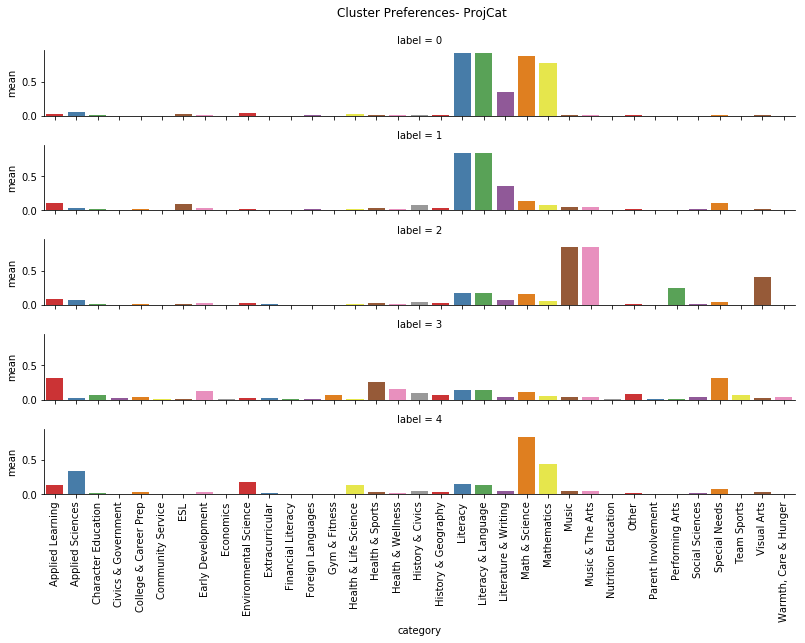

In [24]:
plot_cluster_traits(donorFeatureMatrixNoAdj, 'ProjCat', clusterLabel)

#### Here we plot the preference (Normalized by subtracting the mean prefrence)
Negative # means dislike the subject category compared to average donor<br>
Postive # means prefer the subject category compared to average donor

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\seaborn\axisgrid.py:703: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



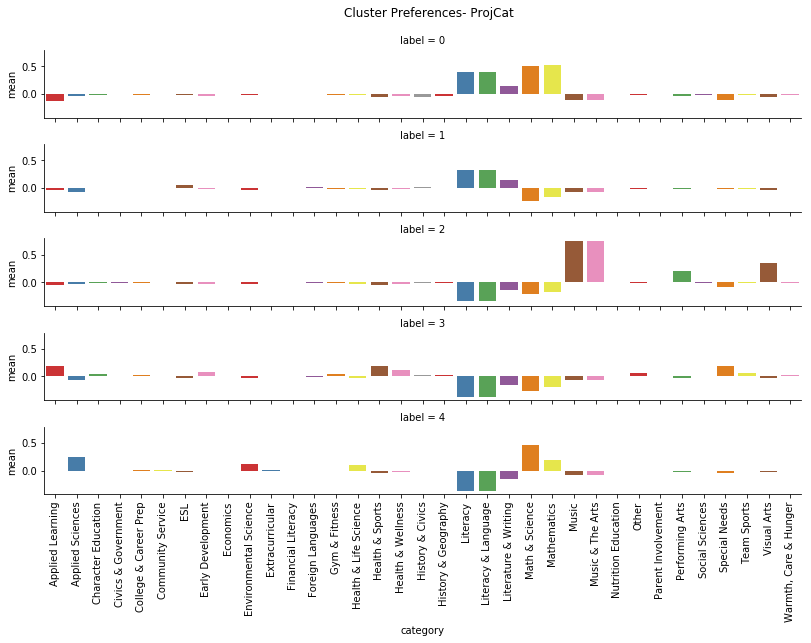

In [25]:
plot_cluster_traits(donorFeatureMatrix, 'ProjCat', clusterLabel)

#### Run the cluster for all the features instead of only on project categories

In [29]:
# Run K-means model on donor FeatureMatrix 
k_means = cluster.KMeans(n_clusters=5)

# Group using project categories
colsInclude = list(donorFeatureMatrix.loc[:,'Project Type_Professional Development': 'Percentile_Dist_max'].columns)
result = k_means.fit(donorFeatureMatrix[colsInclude])

# Get the k-means grouping label
clusterLabel_1 = result.labels_


C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\seaborn\axisgrid.py:703: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



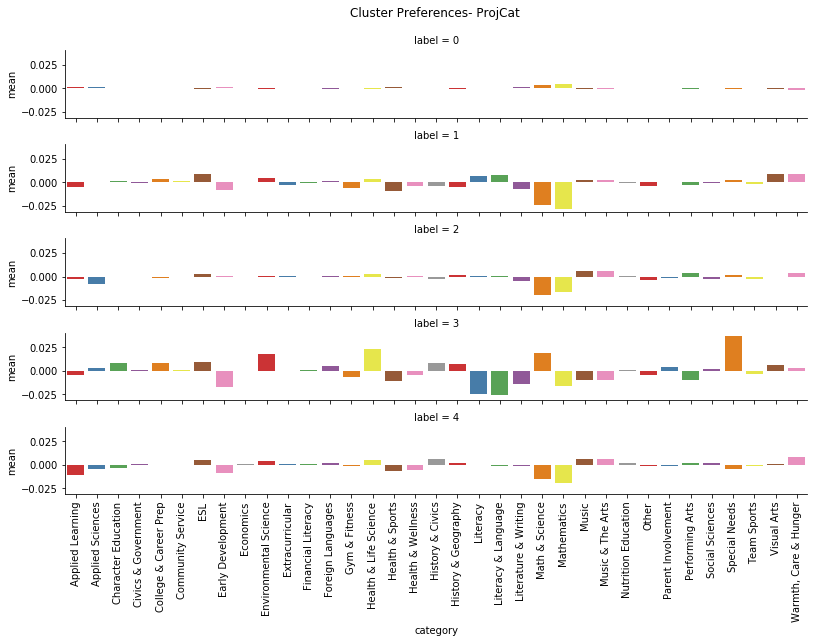

In [30]:
plot_cluster_traits(donorFeatureMatrix, 'ProjCat', clusterLabel_1)

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\seaborn\axisgrid.py:703: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



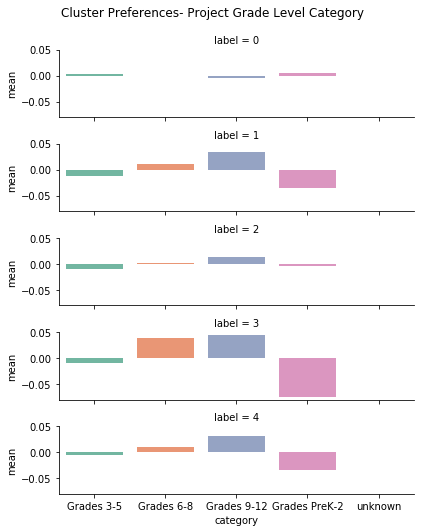

In [31]:
plot_cluster_traits(donorFeatureMatrix, 'Project Grade Level Category', clusterLabel_1)

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\seaborn\axisgrid.py:703: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



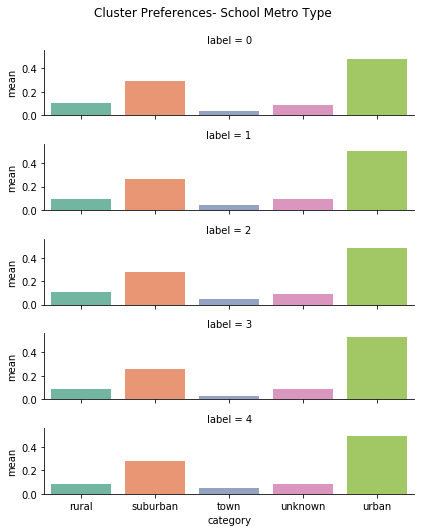

In [32]:
plot_cluster_traits(donorFeatureMatrixNoAdj, 'School Metro Type', clusterLabel_1)

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\seaborn\axisgrid.py:703: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



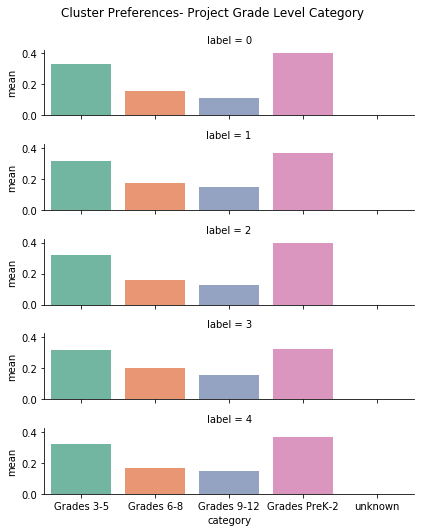

In [33]:
plot_cluster_traits(donorFeatureMatrixNoAdj, 'Project Grade Level Category', clusterLabel_1)

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\seaborn\axisgrid.py:703: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



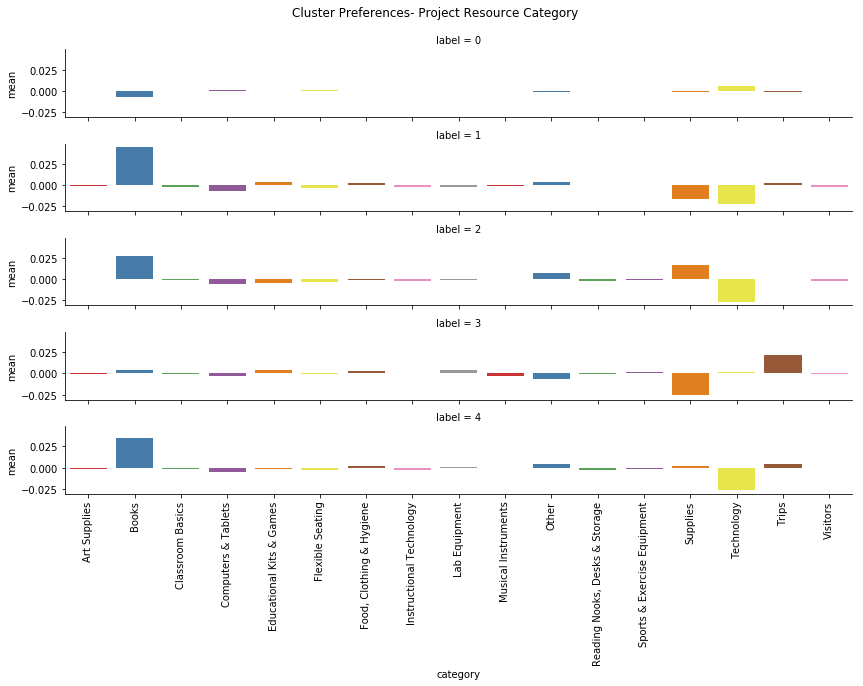

In [34]:
plot_cluster_traits(donorFeatureMatrix, 'Project Resource Category', clusterLabel_1)

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\seaborn\axisgrid.py:703: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



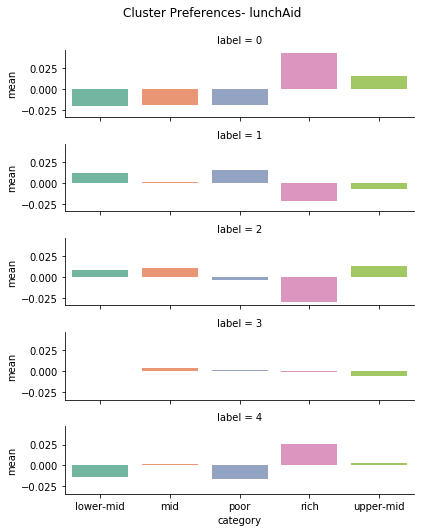

In [35]:
plot_cluster_traits(donorFeatureMatrix, 'lunchAid', clusterLabel)

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\seaborn\axisgrid.py:703: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



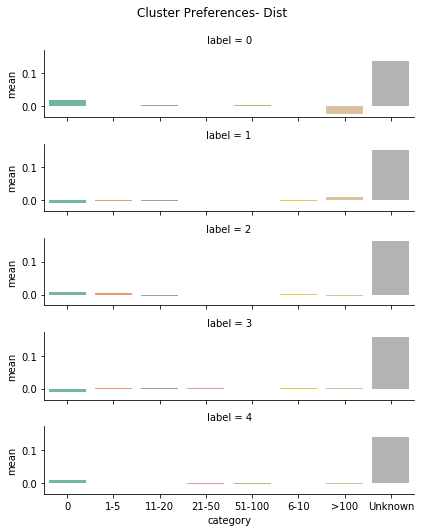

In [36]:
plot_cluster_traits(donorFeatureMatrix, 'Dist', clusterLabel)

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\seaborn\axisgrid.py:703: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



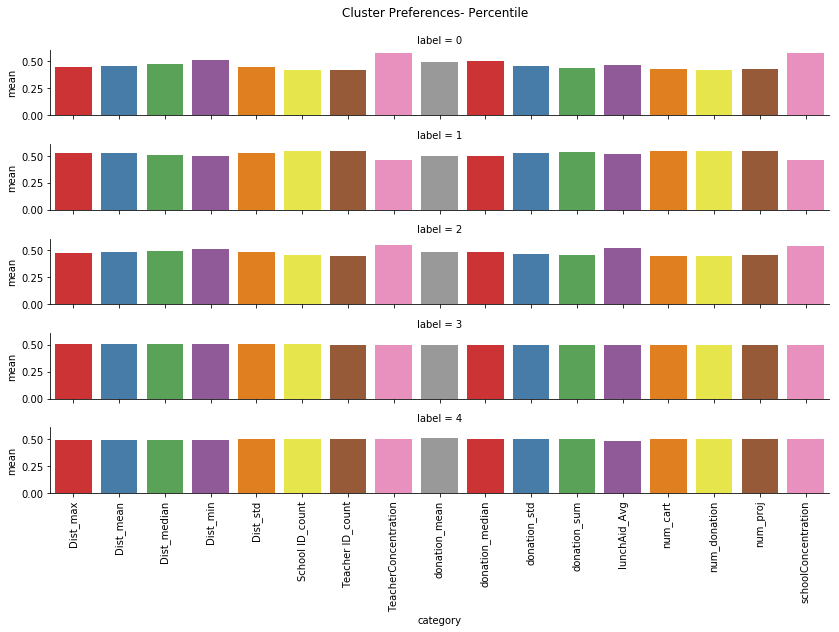

In [37]:
plot_cluster_traits(donorFeatureMatrix, 'Percentile', clusterLabel)

C:\Users\kikimeow\Anaconda3\envs\tf\lib\site-packages\seaborn\axisgrid.py:703: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



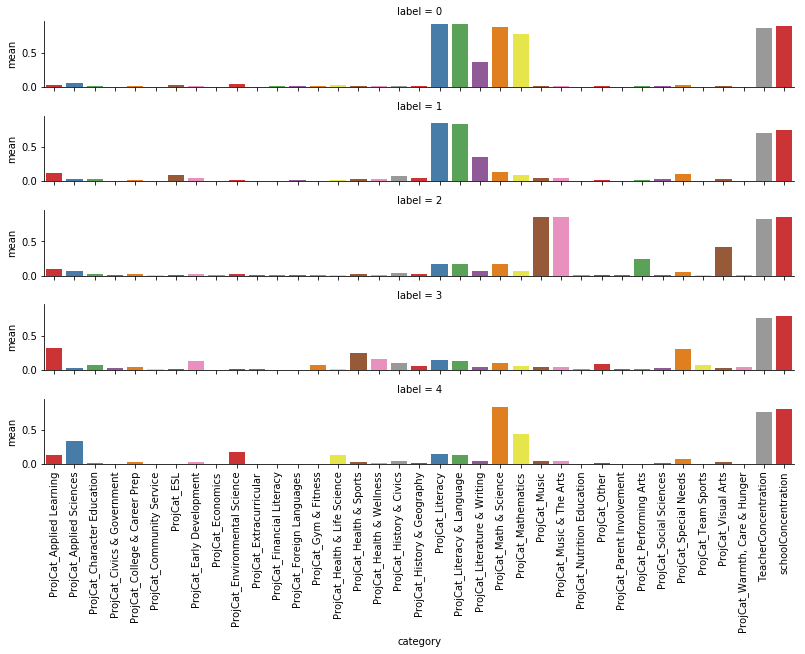

In [38]:
chart = donorFeatureMatrixNoAdj.filter(regex=r'Concentration|ProjCat')
chart['label'] = clusterLabel
chart = chart.groupby(['label']).mean().reset_index()
chart_melt = pd.melt(chart, id_vars = ['label'], value_vars = chart.columns[1:], var_name='category', value_name = 'mean')
chart_melt = chart_melt.sort_values(by = ['label', 'category']).reset_index(drop = True)

g = sns.FacetGrid(chart_melt, row = 'label', size=1.5, aspect=8)  # size: height, # aspect * size gives the width
g.map(sns.barplot, 'category', 'mean', palette="Set1")
g.set_xticklabels(rotation=90)
g.fig.subplots_adjust(top=0.9)
